# Comparison of ML model and OGGM, PYGEM, GLOGEM on monthly glacier-wide mass balance

In [1]:
# Import libraries
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from tqdm import tqdm
from itertools import product
import dill as pickle
import xarray as xr
import seaborn as sns
from scipy.stats import gaussian_kde

import seaborn as sns
import matplotlib.lines as mlines
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Read dataframe of ML predictions
filepath_ML = 'C:/Users/kasj/ML_MB_Norway/Data/glacier_predictions/with_predictions_monthly/ML_monthly_mb_glacierwide.nc'

with xr.open_dataset(filepath_ML) as ds_ML_out:
    ds_ML = ds_ML_out


In [3]:
ds_ML

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2021-12-01
Data variables:
    mb_monthly  (ID, time) float32 ...

In [4]:
# OGGM
filepath_OGGM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/OGGM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_OGGM) as ds_OGGM_out:
    ds_OGGM = ds_OGGM_out

# GloGEM
filepath_GLOGEM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/GloGEM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_GLOGEM) as ds_GLOGEM_out:
    ds_GLOGEM = ds_GLOGEM_out

# PyGEM
filepath_PYGEM = 'C:/Users/kasj/ML_MB_Norway/Data/data_model_comparison/PyGEM_monthly_mb_glacierwide.nc'
with xr.open_dataset(filepath_PYGEM) as ds_PYGEM_out:
    ds_PYGEM = ds_PYGEM_out


In [5]:
ds_OGGM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 708)
Coordinates:
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2019-09-01
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
Data variables:
    mb_monthly  (ID, time) float64 ...

In [6]:
ds_GLOGEM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 480)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1979-10-01 1979-11-01 ... 2019-09-01
Data variables:
    mb_monthly  (ID, time) float64 ...

In [7]:
ds_PYGEM

<xarray.Dataset>
Dimensions:     (ID: 32, time: 744)
Coordinates:
  * ID          (ID) object '0287' '0295' '0434' '0449' ... '2963' '2966' '2969'
  * time        (time) datetime64[ns] 1960-10-01 1960-11-01 ... 2022-09-01
Data variables:
    mb_monthly  (ID, time) float64 ...

## Plot all glacier-wide monthly mass balances

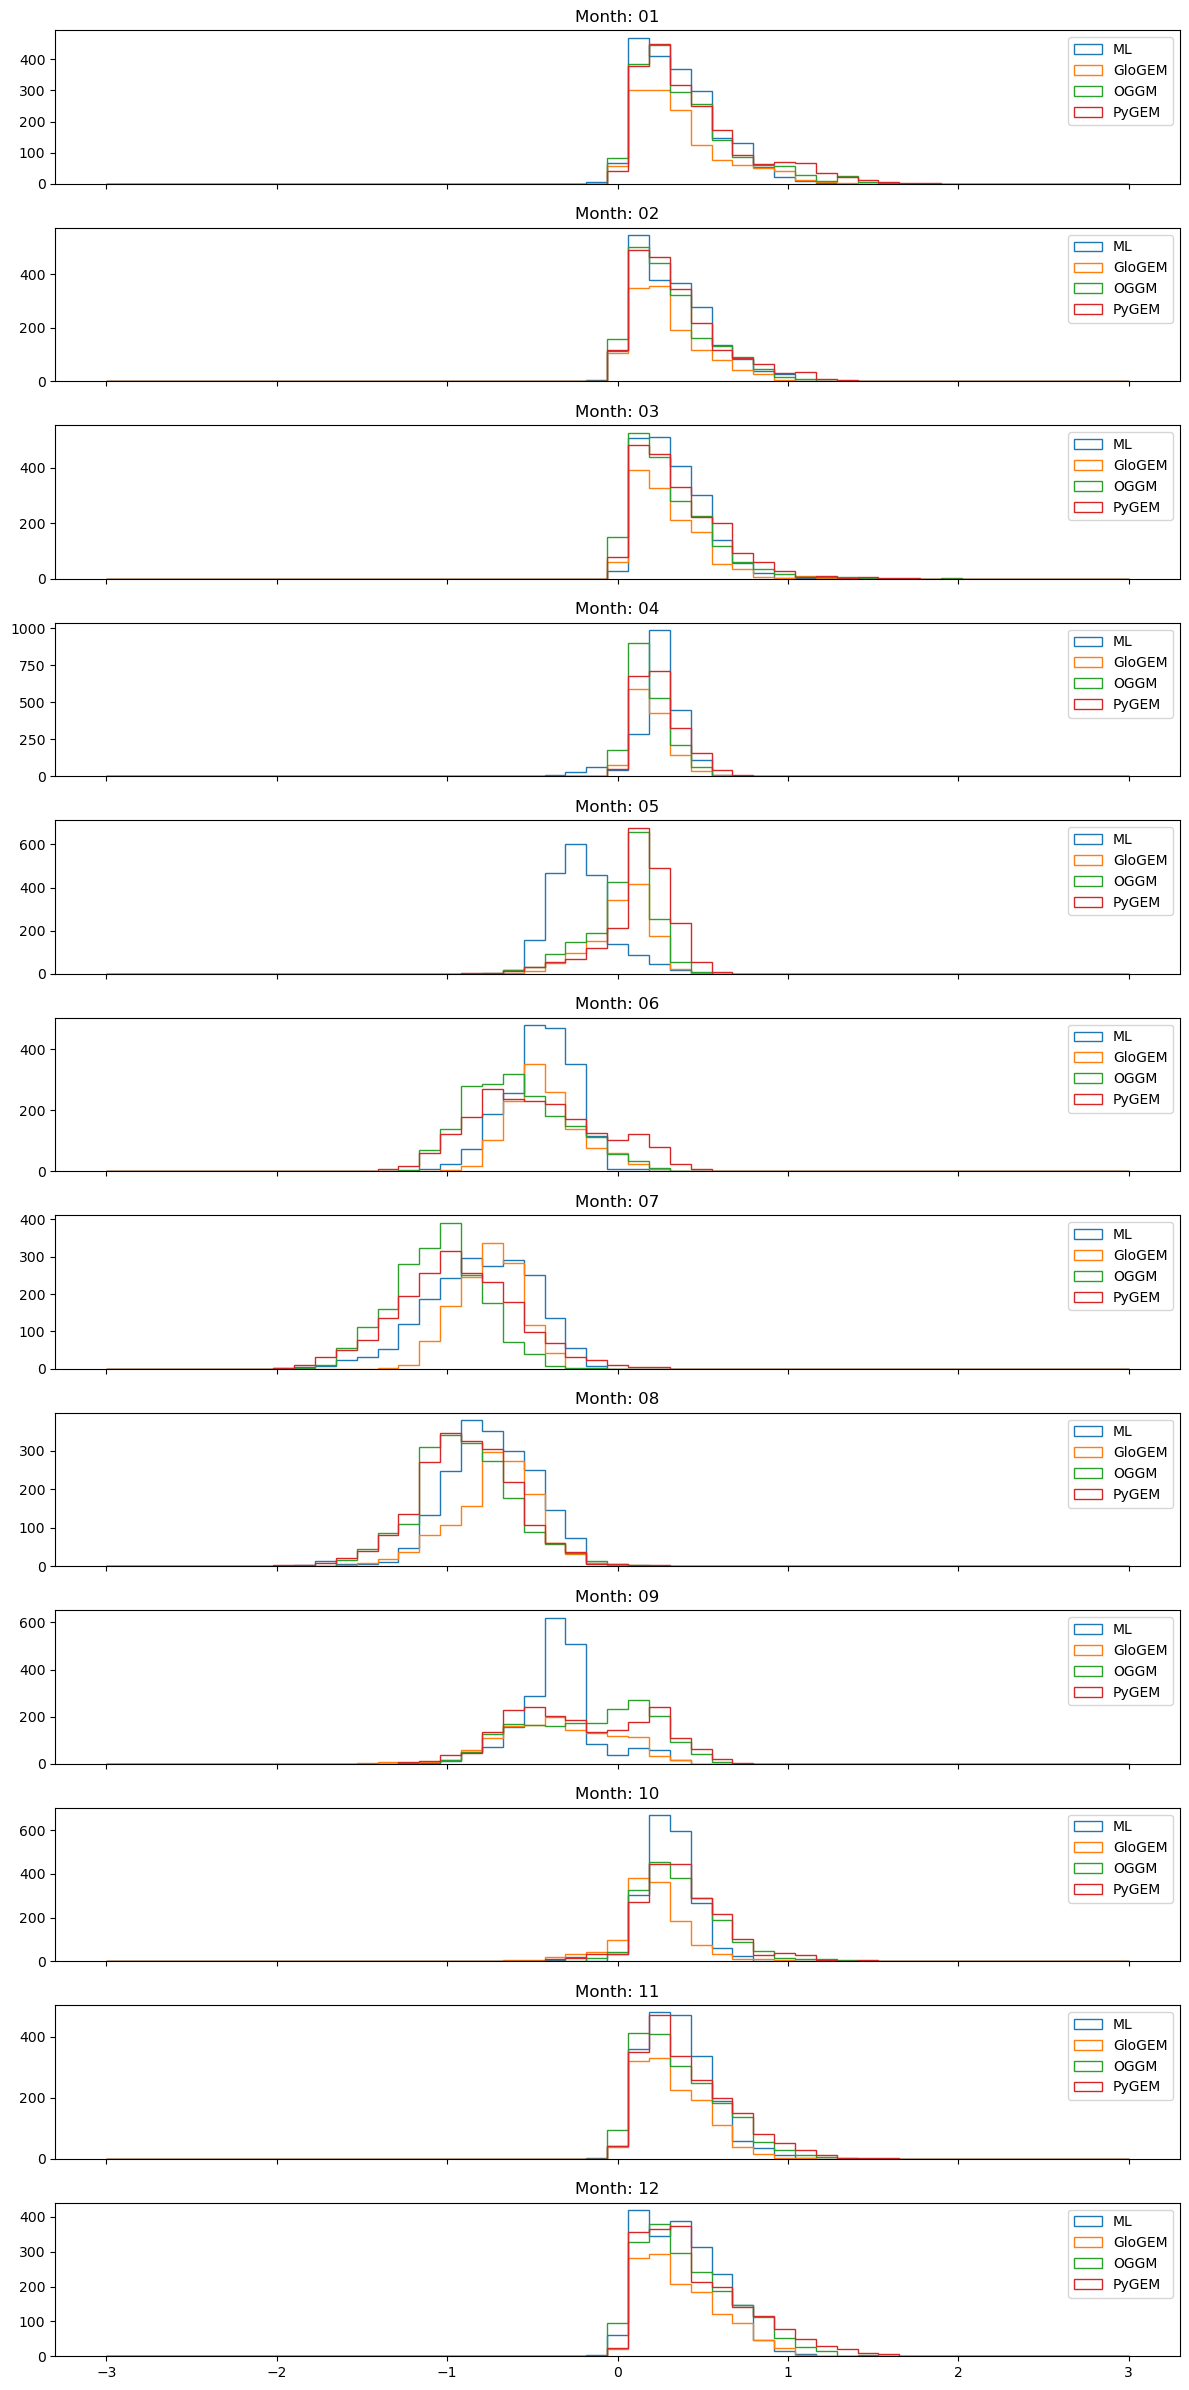

In [9]:
# plot test_pred and use X_test to get months
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 24), sharex=True)

# List of datasets
datasets = [('ML', ds_ML), ('GloGEM', ds_GLOGEM), ('OGGM', ds_OGGM), ('PyGEM', ds_PYGEM)]
#datasets = [('GloGEM', ds_GLOGEM), ('OGGM', ds_OGGM), ('PyGEM', ds_PYGEM)]

bins = np.linspace(-3, 3, 50) 

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    
    # Histograms for datasets
    for label, ds in datasets:
        data = ds['mb_monthly'].sel(time=ds['time.month'] == month).values.flatten()
        data = data[~np.isnan(data)]
        ax.hist(data, bins=bins, label=label, histtype='step')

    ax.set_title(f'Month: {month:02d}')
    ax.legend()

plt.tight_layout()
plt.show()

## Plot glacier-wide monthly mass balances for common time period

In [14]:
# Use time range from GloGEM: 1979-10-01 ... 2019-09-01
start = '1979-10-01'
end = '2019-09-01'
start_dt = pd.to_datetime(start).to_numpy()
end_dt = pd.to_datetime(end).to_numpy()

ds_ML_crop = ds_ML.sel(time=slice(start_dt, end_dt))
ds_OGGM_crop = ds_OGGM.sel(time=slice(start_dt, end_dt))
ds_PYGEM_crop = ds_PYGEM.sel(time=slice(start_dt, end_dt))
ds_GLOGEM_crop = ds_GLOGEM.sel(time=slice(start_dt, end_dt))

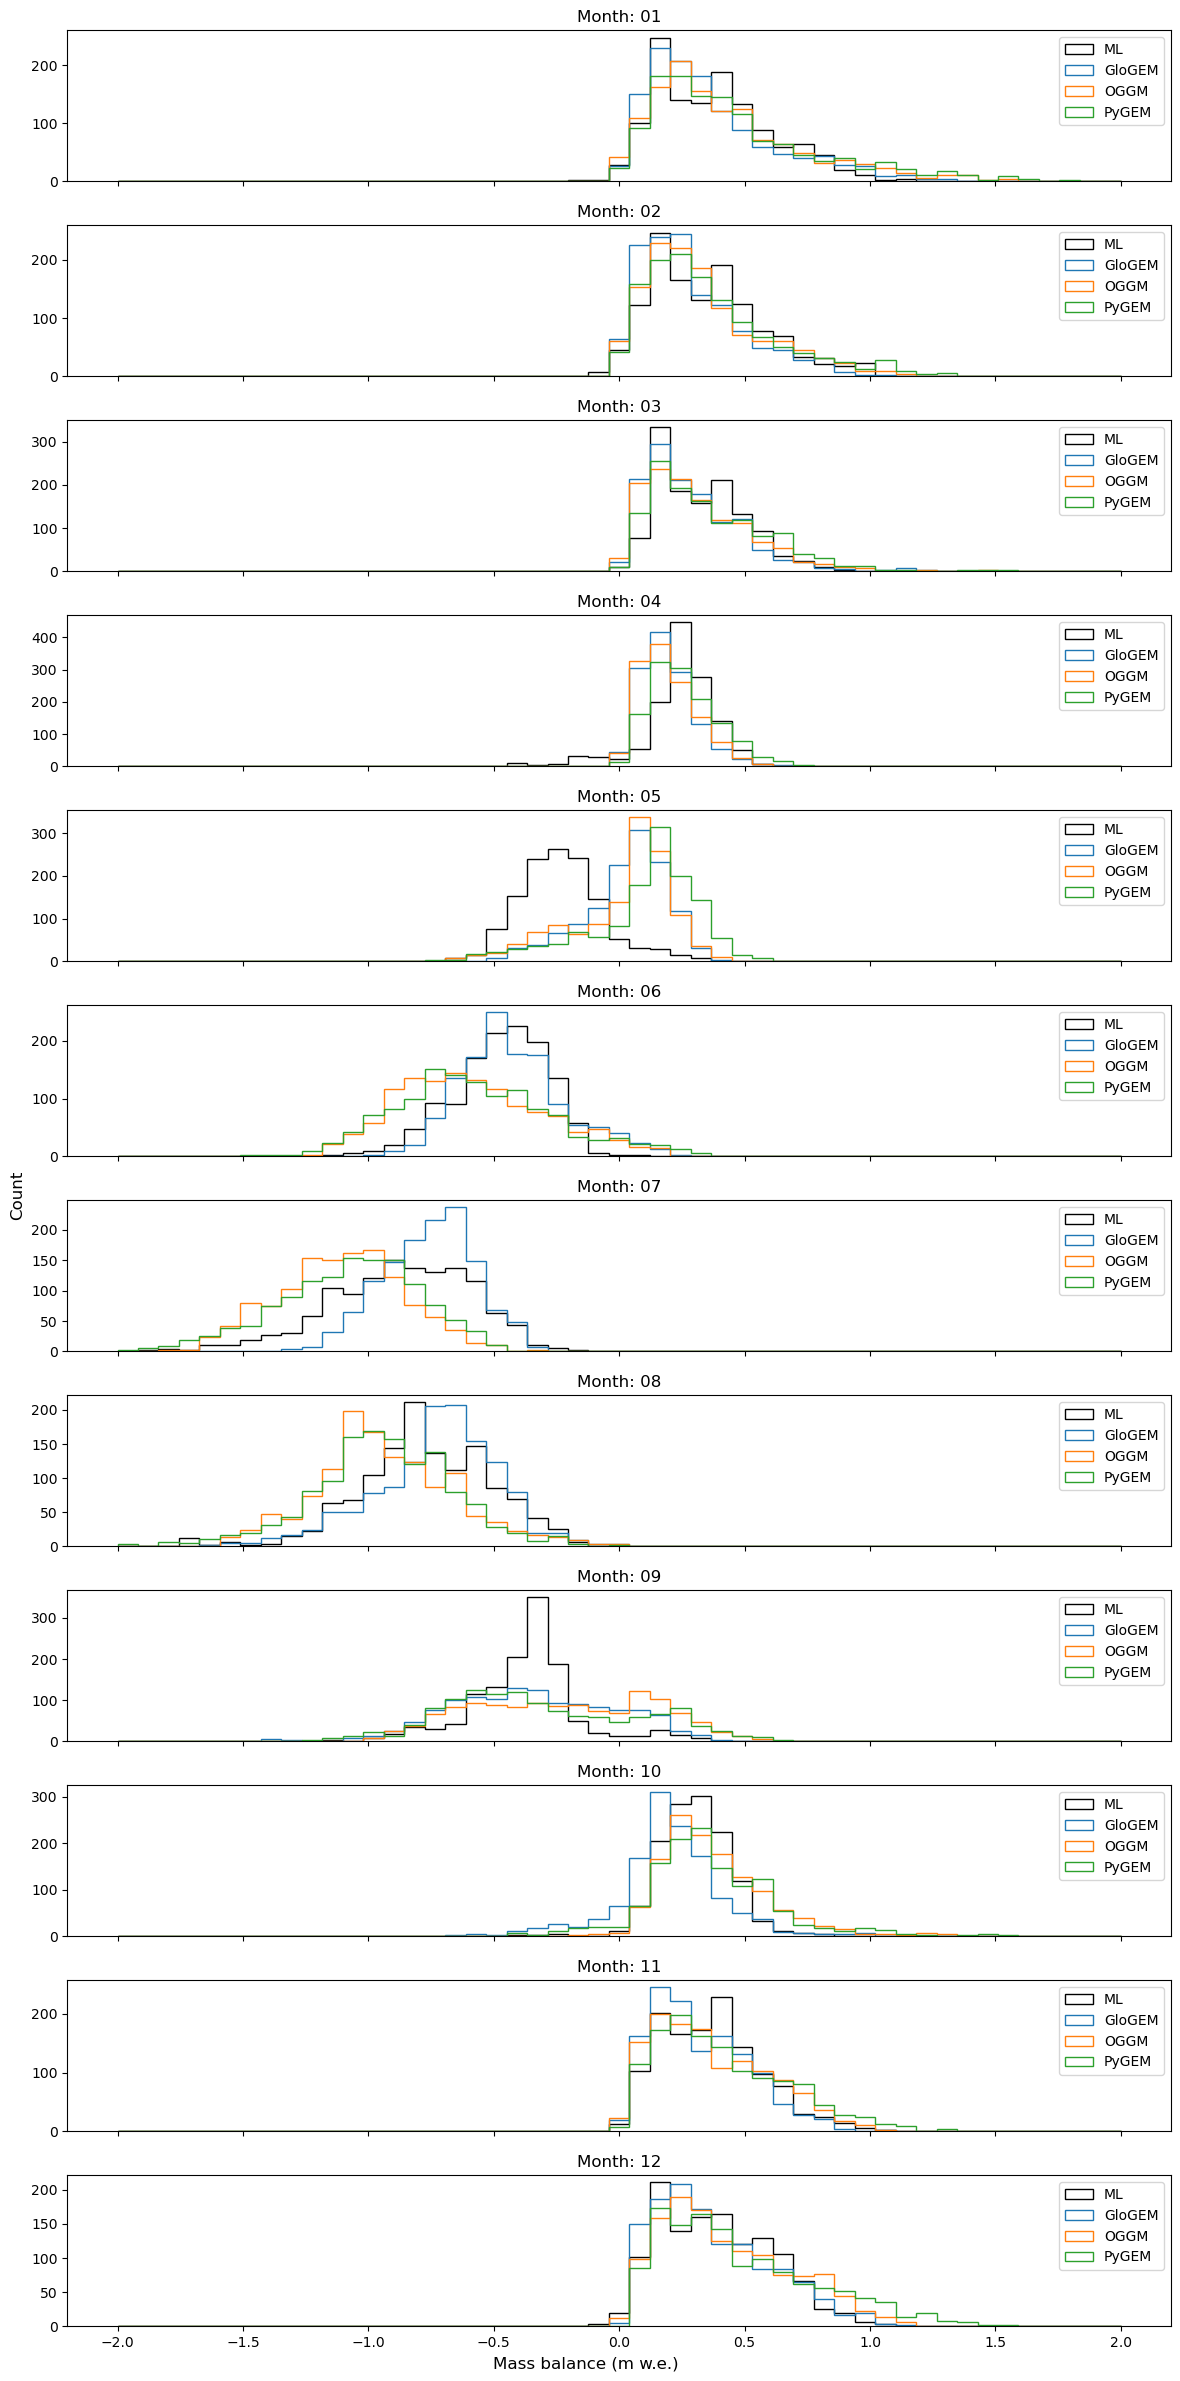

In [21]:
# plot test_pred and use X_test to get months
month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

fig, axes = plt.subplots(nrows=12, ncols=1, figsize=(12, 24), sharex=True)

# List of datasets
datasets = [('ML', ds_ML_crop, 'k'), ('GloGEM', ds_GLOGEM_crop, 'C0'), ('OGGM', ds_OGGM_crop, 'C1'), ('PyGEM', ds_PYGEM_crop, 'C2')]

bins = np.linspace(-2, 2, 50) 

for i, ax in enumerate(axes.flatten()):
    month = i + 1
    
    # Histograms for datasets
    for label, ds, color in datasets:
        data = ds['mb_monthly'].sel(time=ds['time.month'] == month).values.flatten()
        data = data[~np.isnan(data)]
        ax.hist(data, bins=bins, label=label, histtype='step', color=color)

    ax.set_title(f'Month: {month:02d}')
    ax.legend()

fig.supylabel('Count')
fig.supxlabel('Mass balance (m w.e.)')
plt.tight_layout()
plt.show()